<div style="text-align: right"><sub>This notebook is distributed under the <a href="https://creativecommons.org/licenses/by-sa/4.0/" target="_blank">Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license</a>.</sub></div>
<h1>Hands on Machine Learning  <span style="font-size:10px;"><i>by <a href="https://webgrec.ub.edu/webpages/000004/ang/dmaluenda.ub.edu.html" target="_blank">David Maluenda</a></i></span></h1>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://atenea.upc.edu/course/view.php?id=95161" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/upc_logo_49px.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/dmaluenda/hands_on_machine_learning/blob/master/02_Training.ipynb" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/dmaluenda/hands_on_machine_learning/blob/master/02_Training.ipynb" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/02_Training.ipynb"  target="_blank"
          download="02_Training">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

# $\text{II}$. Training Neural Networks with Pure Python

Hands on "Machine Learning on Classical and Quantum data" course of
[Master in Photonics - PHOTONICS BCN](https://photonics.masters.upc.edu/en/general-information)
[[UPC](https://photonics.masters.upc.edu/en) +
[UB](https://www.ub.edu/web/ub/en/estudis/oferta_formativa/master_universitari/fitxa/P/M0D0H/index.html?) +
[UAB](https://www.uab.cat/web/estudiar/la-oferta-de-masteres-oficiales/informacion-general-1096480309770.html?param1=1096482863713) +
[ICFO](https://www.icfo.eu/lang/studies/master-studies)].

**Tutorial 2**

This notebook shows how to:
- manage ground truth dataset for supervised learning
- understand the cost/loss function concept
- implement a stochastic gradient descent to fit arbitrary nonlinear functions
- implement backpropagation in pure python
- train a deep fully connected net to reproduce an image
- differentiate 'hyperparameters' from 'parameters'
- choose a learning rate (and its meaning)
- choose a batch size (and its meaning)
- differentiate training, validation and test datasets
- initialize a neural network
- get the 'epochs' concept
- save and load networks
- view inside a neural network

**References**:

[1] [Machine Learning for Physicists](https://machine-learning-for-physicists.org/) by Florian Marquardt.
<br>
[2] [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html): the fundamental package for scientific computing in Python.
<br>
[3] [Matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html): a comprehensive library for creating static, animated, and interactive visualizations in Python.<br>
[4] "Back-Propagation is very simple. Who made it Complicated?", Prakash Jay at [medium](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c).
<br>
[5] ["A Step by Step Backpropagation Example"](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/), Matt Mazur.
<br>
[6] [Backpropagation Step by Step](https://hmkcode.com/ai/backpropagation-step-by-step) from hmkcode.

## 0. Imports: only numpy and matplotlib

In [1]:
import os

# get the "numpy" library for linear algebra
import numpy as np

# get "matplotlib" for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300  # highres display
from matplotlib.axes._axes import _log as mpl_ax_logger
mpl_ax_logger.setLevel('ERROR')  # ignore warnings

# for nice inset colorbars:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import requests  # to download files (for data/images)
from io import BytesIO
import imageio   # to deal with images

# time control to count it and manage it
from time import time, sleep

# For simple animation
from IPython.display import clear_output

def get_npz_remote(url):
    """ This is a wrapper to get a npz from a url """
    r = requests.get(url, stream=True)
    return BytesIO(r.raw.read())

## 1 Stochastic Gradient Descent
### 1.1 Function definition and dataset

Since neural networks usually have several input and output neurons, and typically many trainable parameters $\omega$, it is not easy to visualize the training mechanism. Then, let's play with a toy model where we will have just one single input $x$, one single output $y$, and two trainable parameters $\omega=(\omega_0, \omega_1)$.

Let's define a non-linear function to connect $y$ from $x$, through $\omega$, for instance

\begin{equation}
\tag{2.1}
g(x; \omega) = \frac{\omega_0}{(x - \omega_1)^2 + 1} = y
\end{equation}

Notice that this function $g(\cdot)$ do NOT represent any kind of neuron connection within a neural network, neither any activation function. It is just an example of nonlinear function chosen only for illustrative purposes. Although, a neural network can be understood as a non lineal function that connects $\vec{x}$ input to $\vec{y}$ output neurons through some $w$ trainable parameters.

<hr>

Then, define a function to return the $y$ predicted result for a given $x$ and $\omega$ (input arguments). This would act as the network prediction inference. 

Let's initialize our pseudo-network by setting arbitrary parameters for $\omega$.

Thus, declare a variable to store $\omega$ and initialize it to $\omega=(-2, 2)$, for instance.

We have a dataset with one million of $(x, y)$ pairs, and we want to train our pseudo-network (model) to reproduce this dataset.

To train the model (or fit the function), we will follow the supervised learning strategy. Typically, the dataset used in supervised learning is called ***ground truth***, because it is the truth where we fix our target.

Load the `curve_fitting_data.npz` numpy file to get the ground truth.

> Check the [`numpy.load()`](https://numpy.org/doc/stable/reference/generated/numpy.load.html) documentation.

NpzFile 'object' with keys: x, y
(1000000,) (1000000,)


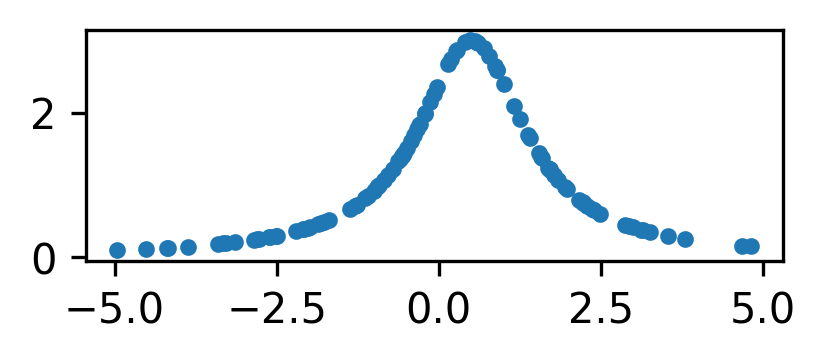

In [2]:
URL_function = 'https://github.com/dmaluenda/hands_on_machine_learning/raw/master/data/curve_fitting_data.npz'
data = np.load(get_npz_remote(URL_function))
print(data)

x = data['x']
y = data['y']

print(x.shape, y.shape)

plt.figure(figsize=(3,1))
plt.plot(x[:100], y[:100], '.')  # we plot just the first 100 items, to save time and better visualize
plt.show()

Since this dataset is huge, write a function to return two batches arrays (for $x$ and $y$) of a certain length given by the $M$ `batchsize` argument.

So, randomly pick a $M$ number of elements on the whole $x$ input array and their corresponding $y$ output pairs.

Check your function by plotting a new batch of $M=40$ data points and compare the shape with the one above. They have to be very similar.

Let's compare the randomly initialized model with the ground truth dataset, using just some randomly picked points.

Then, plot the network prediction for that same input, in the same figure.

> Check the `plt.scatter()` matplotlib's function.

Add a legend to easily identify which data is from the dataset and which is the prediction.

Set the $x$-axis limits to $[-4, 4]$

### 1.2 Cost function (also known as loss function)

The fitting shown above is probably poor. However, we need to quantify the 'quality' of the current fitting by a numeric value. In other words, a cost function is a function to evaluate the quality of the fitting for that given trainable parameters.  We will use the most simple cost function: the square of the discrepancy between the predicted values with the ground truth, averaged over all the evaluated samples. Notices that is a single value, known in this case as mean squared error (MSE).

\begin{equation}
\tag{2.2}
C(\omega; y) = \frac{1}{2} \left\langle \left[ y\,(x; \omega) - y_{\rm truth}(x)\right]^2 \right\rangle_{\!_M}
\end{equation}

where $y(x; \omega) = g(x; \omega_0, \omega_1)$ is the prediction inferred by the current state of the model (given for that specific $\omega$ parameters), and over a certain $x$ input set. $y_{\rm truth}(x)$ is the output pair of every $x$ input, taken from the ground truth dataset. $\left\langle \cdot \right\rangle_{\!_M}$ denotes the average over all $M$ evaluated samples.

> the $1/2$ factor is just to make things easier when deriving that cost function, as we will see in a while.

Conceptually, the cost function should not depend on any specific $x$ input data, nor on $y$ output, since it evaluates the fitting in whole terms. However, the cost function $C$ indirectly depends on the dataset $(x, y)$, see Eq. (2.2). Even thought, the main dependency is on the $\omega$ free parameters, and $x$ and $y$ is just the supporting context on that single computation. We will focus on this in a while.

[Check this to see more cost/loss functions](https://www.theaidream.com/post/loss-functions-in-neural-networks).

<hr>

Usually the cost is calculated just for validation purposes. For fitting/training purposes, its derivative makes the work. However, we want to visualize its evolution in this example.

Thus, write a function that returns the MSE-cost for a given set of pairs of predicted and true values.

Since this example have only two trainable parameters, it is worth to check how the cost looks in what is called the *cost landscape*. This is an image where their axes represent the trainable parameters and the color is for the cost reached by the parameters' combination on that $(\omega_0, \omega_1)$ point.

Create a function which returns a $40\times40$ matrix containing the MSE-cost when $\omega_0$ is in range $[-3, 6]$ and $\omega_1$ in $[-2, 3]$. The MSE-cost have to be evaluated using a given $(x, y)$ values from the dataset as argument.

Run this function using $M=20$ randomly picked $(x,y)$ samples on the dataset, and depict the obtained matrix with the `imshow` function. This is the cost landscape. 

Run several times this code cell. Is the landscape changing? Slightly or greatly? Why?

What happens when using more/less randomly picked samples, by increasing/decreasing $M$ (this is the `batchsize`)?

Should the cost landscape ideally depend on the specific $(x, y)$ set of values?

### 1.3 Stochastic gradient descent

The gradient descent algorithm is based on stepping down on the cost landscape to reach the minimum cost, i.e. following the gradient of the cost function (indeed, just the opposite, since gradient is for stepping up, but it is the same with a minus sign).

In this example, we are dealing with just two trainable parameters, then the cost landscape have just two dimensions, and it is quite easy to explore the whole plane (just like before) to find the minima. However, this is not possible when dealing with many trainable parameters (i.e. high dimensional space). Therefore, the gradient descent is a strategy to find the minima of a high dimensional function, where the whole landscape is unknown.

In math, the gradient is typically done over the space coordinates ($x$, $y$, $z$...). However, the cost function depends on the trainable parameters $\omega$. In other words, training is to modify $\omega$ to get better results in prediction/inference time (by reducing the cost function). Thus, the gradient here is a vector, whose components are the partial derivatives respect to each trainable parameter $\omega_i$.

\begin{equation}  \tag{2.3}
\vec{\nabla}_{\!\!\omega} C(\omega; y) = \left( \frac{\partial C(\omega; y)}{\partial \, \omega_0} \; , \;  \dots \; , \; \frac{\partial C(\omega; y)}{\partial \, \omega_i} \; , \; \dots \; , \; \frac{\partial C(\omega; y)}{\partial \, \omega_{N_{\omega}}} \right)
\end{equation}

where $C(\omega; y)$ is the cost function and depends essentially on the different parameters $\omega_i$ ; ($i=0\dots N_{\omega}$).
As said before, take into account that $x$ and $y$ are here just like the environment where to compute the cost, but they do not play any other role in the training. All training focus is over the $\omega$ trainable parameters, not over $(x,y)$. However, we need some data to compute the cost, to make a fitting. Since we are changing the set of data points, the cost landscape is slightly changing on every iteration. This is the *stochastic-ness* of the process.

Remember, the goal of the training is to update the trainable parameters somehow. Then, the stochastic gradient descent consist on doing steps according to the partial derivative of the cost function, over the parameter to be updated. However, cost does not depend directly on $\omega$, but it indirectly does through the inference function $y=g(x;\omega)$. So, it is worth to apply the chain rule for the derivatives.

$$\omega_i^{\text{new}} = \omega_i - \eta \, \delta(\omega_i) = \omega_i - \eta \, \frac{\partial C(\omega;y)}{\partial \omega_i} \quad ; \quad (i=0,N_{\omega})$$
\begin{equation}\tag{2.4}
 = \omega_i - \eta \, \frac{\partial C(\omega;y)}{\partial y(x;\omega)} \, \frac{\partial y(x;\omega)}{\partial \omega_i}\quad \quad \quad \quad \quad \quad \;\;\,
\end{equation}
$$\ = \omega_i - \eta \,  \left\langle \big[ y(x;\omega_0, \omega_1) - y_{\rm truth}(x) \big] \, \frac{\partial y(x; \omega)}{\partial \omega_i} \right\rangle_{\!\!_M}$$


where $\eta$ is the learning rate (how fast we want to progress during the training) and $\delta(\omega_i)=\frac{\partial C(\omega;y)}{\partial \omega_i}$ is the gradient step for each $\omega_i$ trainable parameter.

$\frac{\partial C(\omega;y)}{\partial y(x;\omega)}$ is easily derived from Eq. (2.3) and it is just a scalar factor (not a vector). It basically contains the inference of the current model over an input and its comparison with the ground truth.

Finally, $\frac{\partial y(x;\omega)}{\partial \omega_i}$ is the analytical gradient of $g(\cdot)$ over the weights, Eq. (2.1). It only depends on the model architecture (relation between inputs, weights and outputs) and it is the core of the backpropagation algorithm.

In this particular case
\begin{equation}\tag{2.5}
\vec{\nabla}_{\!\!\omega} \, y(x;\omega) = \vec{\nabla}_{\!\!\omega} \, g(x;\omega_0, \omega_1) = \left( \dots \; , \; \frac{\partial g(x; \omega)}{\partial \omega_i} \; , \; \dots \right) = \left( \frac{1}{(x - \omega_1)^2 + 1} \; , \; \frac{+2(x-\omega_1)\omega_0}{\left[(x-\omega_1)^2+1\right]^2}  \right)
\end{equation}

Notice that, since we deal with many input samples $x$, all this should be averaged over all $M$ samples, see the angle brackets $\langle \cdot \rangle_{\!_M}$ in Eq. (2.4), coming from Eq. (2.2).

<hr>

Write a function which calculates the gradient step $\delta(\omega) = \frac{\partial C(\omega;y)}{\partial \omega_i}$ in this particular case, for the given $\omega$, $(x, y_{\rm truth})$ ground truth data points and $y$ predicted outputs. 

How many components should this gradient step have?

This function might return not only the $\delta(\omega)$, but also the MSE-cost in the current state and with the current batch of data. This last is just useful to monitor the training process.

Write a function to perform a train step. This is `your_training_function` (needed in a while):

0. The function should take as arguments the current $\omega$ (a list of the parameters), the learning rate $\eta$, and the `batchsize`, in this specific order.
1. Get a random batch of $(x,y_{\rm truth})$ input-output pairs from the dataset, this will be the ground truth in this supervised training step. (Use the function done in Section 1.1)
2. Update the $\omega$ calling to the gradient step function done just before.
3. Return the following variables: the $x$ input batch, the $y_{\rm truth}$ target output, the $y$ predicted output, the $C$ MSE-cost obtained in this step (MSE-cost typically is computed before updating the omegas), and the new $\omega$ parameters (in this specific order).

Follow the instructions 0. and 3. in detail to be able to monitor the training with the fancy function some cells below.

In [ ]:
def your_training_function(omegas, eta, batchsize):

    # your code


    return x, y_truth, y_pred, cost, new_omegas    

Make a loop to apply some training steps (using the function you have just made) and store in a list the MSE-cost returned in every iteration. Plot that list.

Plot the prediction of the model over a random batch of inputs and compare it with the ground truth. This is exactly like at the end of Section 1.1.

Has the fitting improved? Is it good enough?

If not, run again the training loop and plot again the prediction, and compare again it with the ground truth.

How many steps are needed to get an acceptable fitting?

Ok. Now, let's see in more detail what are happening during this training loop.

To do that, we will see how the $\omega$ descend the gradient on the cost landscape.

First, let's define some functions to fancy plot the progress. (just run the next cell)

In [ ]:
def plot_curves(x, true_y, fit_y, legend=True, ax=None):
    ax = plt.gca() if ax==None else ax

    ax1 = ax.scatter(x, true_y, color="blue", label='ground truth')
    ax2 = ax.scatter(x, fit_y, color="orange", label='fitting')
    ax3 = ax.plot([x, x], [true_y, fit_y], 'y:', linewidth=1, 
                  label='deviation')
    
    if legend:
        ax.legend(handles=[ax1, ax2, ax3[0]], loc='upper left', fontsize=6)
    ax.set_xlim(-4,4)
    ax.set_xlabel("$x$")
    ax.set_ylabel(f"$y=f(x;{omegas})$", fontsize=6)

    
def plot_landscape(true_y, true_x, ws, ax=None):
    ax = plt.gca() if ax==None else ax
    
    Nw = 40
    
    # The landscape is on omegas, WHY?
    w0s = np.linspace(-3, 6, Nw)  # exploring from -3 to 6 for th0 (40 samples)
    w1s = np.linspace(-2, 3, Nw)  # exploring from -2 to 3 for th1 (40 samples)

    landscape = np.zeros([Nw, Nw])  # init landscape
    for j0, w0 in enumerate(w0s):
        for j1, w1 in enumerate(w1s):
            pred_y = w0 / ( (true_x-w1)**2 + 1.0 )
            landscape[j1, j0] = 0.5 * np.mean((pred_y - true_y)**2)
    
    im = ax.contourf(landscape, extent=[-3, 6, -2, 3])
    plt.colorbar(im, ax=ax)
    ax.contour(landscape, extent=[-3, 6, -2, 3], colors="white")

    ax.set_xlabel(r'$\omega_0$')
    ax.set_ylabel(r'$\omega_1$')

    
def plot_info(x, true_y, pred_y, omegas, stepping, history, arrows=True):
    """ This is a funtion to plot the progress on the training.
    """
    max_MSE = history.max()*1.1 if history.size>0 else 1  # skipping empty hist.
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(5,3))
    gs = fig.add_gridspec(2, 2, hspace=.35, wspace=.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    plot_curves(x, true_y, pred_y, legend=True, ax=ax1)  # compare fiting with truth
    plot_landscape(true_y, x, omegas, ax2)  # to see the progress

    # plot where we are on the landscape
    ax2.scatter([omegas[0]], [omegas[1]], color="orange")  
    if arrows:  # where we go
        ax2.arrow(*(omegas),*(-stepping), color='yellow',
                  width=0.05, length_includes_head=True)
    
    # let's plot the cost history
    ax3.plot(range(history.size), history, marker='o')
    ax3.set_xlim(0, history.size-1)
    ax3.set_xticks(range(0, history.size, 3))
    ax3.set_ylim(0.0, max_MSE)
    ax3.set_xlabel(r"$step$")
    ax3.set_ylabel(r"$MSE$")
    
    plt.show()

def animated_train(your_func, eta, batchsize, init_omegas=None, nsteps=20):
    if init_omegas is None:
        global omegas  # let's continue where we was
    else:
        omegas = init_omegas

    cost_history = np.zeros(nsteps)
    delta_w = 0
    for n in range(nsteps):  # it can be replaced with a while with some criteria

        old_omegas = omegas.copy()
        x, y_true, y_pred, cost, omegas = your_func(omegas, 0.7, 100)
        delta_w = old_omegas - omegas
        
        # let's plot where we are and where we go
        plot_info(x, y_true, y_pred, old_omegas, delta_w, cost_history, True)
        print('estimated omega:', omegas)
        sleep(0.5)
        
        cost_history[n] = cost
        
        plot_info(x, y_true, y_pred, omegas, delta_w, cost_history, False)
        print('estimated omega:', omegas)
        sleep(0.7)

Run the function below where the first argument is the training function you defined in a couple of cells above.

Play with the parameters `eta` and `batchsize`.

How does it influence learning progress?

In [ ]:
# your_func: The trining funtion defined by your own. It has to follow the given instructions for the arguments and returning variables.
# eta: "learning rate" (gradient descent step size)
# batchsize: stochastic x samples used per step (just a few to be fast)
# itit_omegas: the starting training process

animated_train(your_func=your_training_function, eta=1.85, batchsize=300, init_omegas=[-2.3, 0.8])

Why we are not going directly to the minimum of the landscape?


Why is this algorithm ***Stochastic*** *Gradient Descent*? Check the meaning and reason of a <u>[stochastic](https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/)</u> approach.

### 1.4 Non constant learning rate (Schedule or Adaptive)

**Optional**: Modify `your_training_function` in such a way to run with a non-constant learning rate.

[Check this to know more on learning rate](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

## 2. Backpropagation

Like in the Stochastic Gradient Descent, we update trainable parameters of a neural network (weights and biases) in the following way

\begin{equation} \tag{2.6}
\omega_{ij}^l = \omega_{ij}^l - \eta \, \delta(\omega_{ij}^l)
\end{equation}
\begin{equation} \tag{2.7}
b_{i}^l = b_{i}^l - \eta \, \delta (b_{i}^l)
\end{equation}

where $l=1\dots L$ labels all the net layers, $i=1\dots N_l$ and $j=1\dots N_{l-1}$ label all the $N_l$ neurons of the $l$-th layer, and $\delta (\omega) = \frac{\partial C(\omega;x)}{\partial \omega}$ is the gradient step to update the parameters, where $\omega$ includes, not only all weights, but also all biases.

In neural networks, the cost function $C(\omega;y)$ can have a very deep dependency on weights and biases, especially those corresponding to the first layers. However, this deep dependency can be solved through the derivative chain rule (like before). Moreover, the calculations done to estimate the gradient step for the last layers can be reused for deeper layers, as we recall below.

* **Output layer** ($l=L$):

The gradient step $\delta$ to update weights $\omega^{L}_{ij}$ and biases $b^{L}_{i}$ of the last layer ($l=L$), according to Eq. (2.4), is

\begin{equation} \tag{2.8}
\delta(\omega^L) = \frac{\partial C(\omega;y) }{\partial \omega^L }
                 = \frac{\partial C(\omega;y) }{\partial y^{L}_{i} }\frac{\partial y^{L}_{i} }{\partial \omega^{L} } 
\end{equation}
                        
where $\omega^L$ stands for any trainable parameter on the last layer; both, $\omega^{L}_{ij}$ and $b^{L}_{i}$. Notice that the first factor depends only on the cost function, whereas the second only does on the architecture of the network.

Taking the simple MSE-cost function $C = \frac{1}{2} \left( y_i^L - \hat{y}_i \right)^2$, where $\hat{y}_i=y^{\rm truth}_i$ is the ground truth result for the $i$-th component (neuron) and $y_i^L=y_i^L(x;\omega)$ is the actual value gotten with the current network state; we just simplify the notation.

Notice the current output value can be expressed as a combination of the previous layer: 
\begin{equation} \tag{2.9}
y_i^L = f_L\!\!\left[x_j^{L}\right] =  f_L\!\!\left[\omega_{ij}^{L}y_j^{L-1} + b_i^L\right]
\end{equation}
where $f_l[\cdot]$ is the activation function for the $l$-th layer, then

\begin{equation} \tag{2.10}
\frac{\partial C }{\partial y^{L}_{i} } = \left( y_i^L - \hat{y}_i \right)
\end{equation}

this is just the deviation between the predicted result and the ground truth.

On the other hand,

\begin{equation} \tag{2.11}
\frac{\partial y^{L}_{i} }{\partial \omega^{L}_{ij} } = f'_L\!\!\left[ x_i^L\right] \, y_j^{L-1}
\end{equation}

\begin{equation} \tag{1.12}
\frac{\partial y^{L}_{i} }{\partial b^{L}_{i} } = f'_L\!\!\left[ x_i^L\right]
\end{equation}

These two last expressions only contain the current value returned by certain neurons $y_j^{L-1}$ and the value when using the derivative of the activation function, instead.

For convenience, let's define
\begin{equation} \tag{2.13}
\boxed{ \Delta^{\!L}_i = \left( y_i^L - \hat{y}_i \right) \, f'_L\!\!\left[ x_i^L\right] }
\end{equation}

Finally,

\begin{equation} \tag{2.14}
\boxed{ \delta(\omega_{ij}^L) = \Delta_i^{\!L} \otimes y_j^{L-1} }
\end{equation}
\begin{equation} \tag{2.15}
\boxed{ \delta(b_{i}^L) = \Delta_i^{\!L} }
\end{equation}

These boxed equations are all we need to be able to update the weight and biases of the last layer. Of course, all calculus made above are computed with matrices and vectors of indices $i$ and $j$. Notice that $\otimes$ stands for the outer product, which generates a matrix from two vectors. Moreover, usually it is processed with batches of input-output pairs, where final values are averaged for those batches. An efficient way to implement this in batches is explained at the end of this cell.

* **Last hidden layer**:

The procedure is exactly the same as before. However, in order to update weights $\omega^{L-1}_{jk}$ and biases $b^{L-1}_{j}$ of the last hidden layer ($l=L-1$), Eq. (2.8) becomes

\begin{equation} \tag{2.16}
\delta(\omega^{L-1}) = \frac{\partial {C} }{\partial \omega^{L-1} }
            = \frac{\partial {C} }{\partial y^{L}_{i} }
              \frac{\partial y^{L}_{i} }{\partial y^{L-1}_{j} }
              \frac{\partial y^{L-1}_{j} }{\partial \omega^{L-1} } 
\end{equation}
Therefore,
\begin{equation} \tag{2.17}
{ \delta(\omega_{jk}^{L-1}) = \Delta_i^{\!L} \; \omega_{ij}^L \, f'_{L-1}\!\!\left[ x_j^{L-1}\right] \otimes y_k^{L-2} = \Delta_j^{\!L-1} \otimes y_k^{L-2} }
\end{equation}
\begin{equation} \tag{2.18}
{ \delta(b_{j}^{L-1}) = \Delta_i^{\!L} \; \omega_{ij}^L \, f'_{L-1}\!\!\left[ x_j^{L-1}\right]  = \Delta_j^{\!L-1}}
\end{equation}

* **General formula**:

Notice that Eqs. (2.17, 2.18) can be generalized for any layer $l=L-m$ as
\begin{equation} \tag{2.19}
\boxed{ \delta(\omega_{pq}^{l}) = \Delta_p^{\!l} \otimes y_q^{l-1} }
\end{equation}
\begin{equation} \tag{2.20}
\boxed{ \delta(b_{p}^{l}) = \Delta_p^{\!l} }
\end{equation}
where
\begin{equation} \tag{2.21}
\boxed{ \Delta_{p}^{l} = \Delta_{r}^{\!l+1}  \cdot \omega_{rp}^{l+1} \, f'_{l}\!\!\left[ x_p^{l}\right] } \quad ; \quad (l=L-1\dots 1)
\end{equation}

Notice that Eq. (2.21) shows how the error $\Delta$ done in the prediction is back-propagated according to weights and activations of every layer.

* **General notes**:

Notice that boxed equations contain all the backpropagation process. For Eq. (2.13), we need the prediction $y_i^L$ and the derivative of the last step $f'_L\!\!\left[ x_i^L\right]$. Moreover, we also need all the intermediate values $y_p^{l}$ and their derivatives $f'_l\!\!\left[ x_p^l\right]$ for Eqs. (2.19, 2.20). Therefore, the forward prediction (inference) is needed in every training step, not only to get the cost value and its derivative (Eq. 2.13), but also in such a way to store all intermediate neurons values $y_p^{l}$ and their derivative $f'_l\!\!\left[ x_p^l\right]$. Then, all the effort is to make forward inferences storing the intermediate states and their derivatives and, then, apply the backprogation depicted in Eq. (2.21).

That's it!


* **Implementation in batches**:

As we said before, we must be able to accept input-output pairs in batches in order to increase the performances (in time and in precision, recall stochasticness/batchsize relation). Then, all variables regarding data should earn an extra dimension (weights and the biases, and their gradient steps remain like in equations above, no extra dimension is needed for them). In practice, we need just to be carefully with the shape and order of the products. This is, since we want to average all values over the batches, then to compute Eqs. (2.14, 2.19) we have to do a dot product (sum-product) with the batch index as inner index and divide by the batchsize (in this way, we incorporate the average over the whole batch). Similarly, for Eqs. (2.15, 2.20) we have to sum over the $\Delta$ and divide by the batchsize. In addition, the inner index of $\Delta \cdot \omega$ (in Eq. 2.21) is the repeated index $r$, getting a shape of `batchSize`$\times$`layerSize`. Finally, this is multiplied element-wise for the activation contribution, like in Eq. (2.13).

### 2.1 Implement of backpropagation for a general (fully connected) network

Let's do it step by step.

Firstly, write a function to apply the activation function. It has to be ready for training, it means that it has to return both, the result of applying the activation function, and its analytical derivative. Defining this function will let us to easily replaced with another activation function.

Use the *Sigmoid* as activation function, for instance.

Now, write a function to do a layer step, also ready for training. This is, given an input vector $x$, a weights matrix $\omega$, and a biases vector $b$, compute the matrix operation and, then, apply the activation function and its derivative using the function made before. (This function will be also used in Section 2.3.)

Write now a function to make a forward pass through the whole network for a given input vector $x$, a list of weights $[w]_l$ (one weights matrix for each layer) and a list of biases $[b]_l$ (idem), for $l=1\dots L$, being $L$ the number of layers in the network. Thus, use iteratively the previous function, over a given list of weights and biases.

This is very similar to what you did in Tutorial 1 (inference). However, keep in mind, we want it for training. Therefore, we need, not only the final result (like in prediction), but also all inner states of the neurons $y_q^{\,l}$ and their derivative $y\prime_q^{\,l}=f'_{l}\!\!\left[ x_p^{l}\right]$. So, store and return a couple of list of neuron states $[y_q]_l$, one for the common state and the other for its derivative $[y_q^{\,\prime}]_l$, for $l=1\dots L$.

Write a function to back propagate the error prediction, evaluated by the cost function. Thus, you should take the ground truth $y_i^{\rm truth}$ and the current parameters, i.e. the weights list $[\omega]_l$ and biases list $[b]_l$ in the arguments.

This function have to return the gradient steps $\delta(\omega)$ and $\delta(b)$.

Note that $\delta(\omega)$ and $\delta(b)$ have to be equal in size than $\omega$ and $b$, then, they are list of matrices ($\omega$) and list of vectors ($b$). Thus, you can initialize them using the `np.zeros_like(a)` numpy's function inside a <u>[list comprehension](https://www.geeksforgeeks.org/python-list-comprehension/)</u>.

Then, you can fill their last item following Eqs. (2.14, 2.15), using Eq. (2.13).

Finally, you can fill them recursively backwards following Eqs. (2.19, 2.20), using Eq. (2.21).

Note that you will need all inner states of the neurons $[y_q]_l$ and their derivative $[y^{\,\prime}_q]_l$, so ask for them in the arguments.

Take into account that all data variables has an extra dimension for batch processing and, then, you have to average over that dimension to get a stochastic result.

Let's put it together.

Write a function to perform a training step. This is to update the trainable parameters stepping down the gradient.

To do that, 

1. apply forward pass (inference) through the whole network, while storing the inner states (and their derivative), just by calling the function defined before.

1. take that inner states and apply the backpropagation using the function made before, to get the gradient steps $\delta(\omega)$ and $\delta(b)$.

1. update the weights and biases following the Eqs. (2.6, 2.7).

1. compute the MSE-cost of the network. (You can use the result provided by point 1.)

We will use this function to completely train a network, then it is important to check that:

- it has as argument: the input data $x$, the ground truth $y^{\rm truth}$, the current weights list $[\omega]_l$, the current biases list $[b]_l$, and the learning rate $\eta$.

- it returns: the predicted result $y^L$, the cost $C$, the updated weights list $[\omega^{\rm new}]_l$, and the updated biases list $[b^{\rm new}]_l$

### 2.2 Train a net to fit a 2D function (an arbitrary image) in batches

Use the next nonlinear function as a ground truth, so as the target behavior of the network.
Yes, it is an arbitrary image. However, it can be seen as a non-trivial relation between a couple of inputs $(x_1,x_2)$ (corresponding to every position on the image), and the single output $y_{\rm truth}$ (corresponding to the pixel value).

In [ ]:
# load the pixel image
URL = "https://github.com/dmaluenda/hands_on_machine_learning/raw/master/data/Smiley.png"
face = imageio.v2.imread(requests.get(URL).content)

face = face[2::6,2::6,0]
face = face[:,::-1].astype('float64')  # and flip... to get the right view!

face += np.random.uniform(low=0, high=0.05*face.max(), size=face.shape)

# normalize between 0 and 1
face -= face.min()
face_size = np.shape(face)[0] # assuming a square image!
y_dataset = (face.astype(dtype='float'))/face.max()  # [0, 1]  <--- y_target is the goal of the training
y_dataset = y_dataset.flatten()[:,None]
print(f"{y_dataset=}: {y_dataset.shape=}")

print("")
# single_range = np.arange(-face_size, face_size)/face_size
x1_2D, x2_2D = np.mgrid[-face_size//2:face_size//2, -face_size//2:face_size//2] / face_size
x_dataset = np.stack([x1_2D.flatten(), x2_2D.flatten()], axis=1)     #        <--- x is the input values
print(f"{x_dataset=}: {x_dataset.shape=}")

Then, the dataset is: `x_dataset` and `y_dataset` variables, corresponding to the available inputs and their outputs, respectively. 

Define a function to get a reduced batch of the whole dataset, containing a `batchsize` number of representations of the ground truth.

The function below shows a picture according to certain $\vec{x}_M=(x_1, x_2)_M$ input batch and $y_M$ output batch. It is shown in the `axs` axis argument if it is passed, else it is shown in the active axis (current or new figure). Non set pixels are shown in white (out of the colormap).

Show a batch of `batchsize` $=M=256$ pixel in an image by finishing the next code cell (see comment at the end).

In [ ]:
def imshow_inference(inputs, outputs, ax=None):

    ax = ax or plt.gca()

    image = 1/np.zeros_like(face)  # let's set unexplored points at NaN -> White in imshow (viridis)

    idx = ((inputs+0.5)*face_size).astype(dtype='int')

    image[idx[:,0], idx[:,1]] = outputs[:,0]
   
    im = ax.imshow(image, extent=(-0.5, 0.5, -0.5, 0.5))
    ax.set_title(f"vmin={outputs.min():.2f}\nvmax={outputs.max():.2f}", fontsize=6, y=1, pad=-14)
    ax.set_xlabel("$x_1$", fontsize=4)
    ax.set_ylabel("$x_2$", fontsize=4)
    ax.tick_params(axis='both', labelsize=4)

    

fig, axs = plt.subplots(1, 2, figsize=(2,2))
imshow_inference(x_dataset, y_dataset, ax=axs[0])  # This shows the whole image in the first axis

# Add here you code to depict a batch of the dataset of 256 values on the second axis (axs[1])

As many samples to be computed at once, as better performance in the training (and less stochastic). However, it needs more computational resources (basically, RAM memory and CPU time). How many samples is a reasonable minimum for this example?

### 2.3 Network definition and evaluation

Define a network having 4 layers with 2 input neurons, 50 neurons in the two hidden layers, and 1 single output neuron.

Define an inference function to evaluate the network for a given input and the current state of the model (weights and biases). To apply the activation function, use the same function done before in the Section 2.1. Now it is just to infer a result, so do not store the inner neuron states, neither their derivatives, and just return the final result. This is the prediction inferred.

### 2.4 Neural network training

Run the training step function (backpropagation) several times to train the network and recover the target image (smiling).

Make a loop to apply many times (100k or, even, 1 million) the training step. _-you can stop the running by clicking the STOP button on the bar (ctrl+C in some environs)-_

Before the loop:

 * Set a $\eta$ learning rate (about 1)
 * Set a $M$ batch size, according to your checks before
 * Initialize an empty list to store the cost history.

Inside the loop:
 * Create a batch of data using the function written in Section 2.2.
 * Make a training step using this batch of data, using the last function written in Section 2.1.
 * Append the returned cost value to the cost list.
 * Only after some iterations (let's say 10000), do:
   * Clear any previous figure by typing `clear_output(wait=True)`
   * Create a $2\times2$ subplot. You may set a `figsize=(3,3)` to contain the size of the figure.
   * Call the `imshow_prediction` function to show the last gotten result (over the current batch) on the axis `[0,0]`.
   * Apply the inference function just previously written to the whole `x_dataset` to validate the current state of the network, the result is the $y_{\rm val}$ validation output.
   * Call the `imshow_prediction` function using the whole `x_dataset` and $y_{\rm val}$, on the axis `[0,1]`.
   * Compute the cost $\frac{1}{2}(y_{\rm val}-y_{truth})^2$. Do not average this cost, i.e. it is a flattened image.
   * Call the `imshow_prediction` function using the whole `x_dataset` and the cost just computered in the last point, on the axis `[1,0]`.
   * Plot the cost history on the axis `[1,1]`.

Play with different configurations: learning rate, batch size, number of neurons, number of layers... even, the activation function.

To modify the activation function written in Section 2.1, just re-define it in the cell below, before reinitialize the training again.

Check  https://medium.com/towards-data-science/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79

Comment the results.

## 3. Save and load a model

Where are the information about the model?

Save the information using the `np.savez()` function. Use `*weights_list` and `*biases_list`. See the asterisk in front of the list variables to be able to store them.

Let's see how we can recover a whole neural network model and state.

Load that information again and reproduce the image without making any new training.

## 4. Inside a network

Let's set to 0 all the weights on all neurons of a certain hidden layer, except for one neuron and, then, let's plot the result to check the image produced by that neuron.

In the next cell, a model from internet is download to show this. You can load your own neural network model (weights and biases).

In [12]:
URL_smile_model = 'https://github.com/dmaluenda/hands_on_machine_learning/raw/master/data/02_smile_model_2layers_5neurons_sigmoid.npz'

stored_model = np.load(get_npz_remote(URL_smile_model))  # You can replace 'get_npz_remote(...)' with your path set in last section.

In [11]:
w_stored = [stored_model["arr_"+str(i)] for i in range(len(stored_model)//2)]
b_stored = [stored_model["arr_"+str(len(stored_model)//2+i)] for i in range(len(stored_model)//2)]

layers = len(w_stored)-1
neurons = w_stored[1].shape[1]

fig, axs = plt.subplots(neurons, layers, figsize=(layers, neurons))

y_predi_all_cumulate = np.zeros_like(y_dataset) 

for l in range(layers):
    for n in range(neurons):
        w_ON = w_smile[l+1][n,:].copy()
        
        w_current = np.zeros_like(w_stored[l+1])
        w_current[n,:] = w_ON

        w_list = w_stored.copy()
        w_list[l+1] = w_current
        
        y_predi_all = inference(x_dataset, w_list, b_stored)
        imshow_prediction(x_dataset, y_predi_all, axs[n, l])

BadZipFile: Bad magic number for file header

## 5. Play with https://playground.tensorflow.org 